In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "PH_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

# Load Files

In [2]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_PH_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
len(windmill)

2

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [5]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [6]:
df = features.parallelize_extract(df)

parallelize_extract time:  101.8706328868866


In [7]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [8]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [9]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [10]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [11]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [12]:
len(df_train)

17474

In [13]:
df_train.to_parquet(constant.PH_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.PH_SC_EVL_path, index=False)

# Neural Network Train

In [2]:
df_train = pd.read_parquet(constant.SL_SC_TRAIN_path)

In [9]:
import numpy as np
np.unique(df_train["TIME_CET"][:9].astype(str).to_list)

array([<bound method IndexOpsMixin.tolist of 0    2018-03-01
1    2018-03-01
2    2018-03-01
3    2018-03-01
4    2018-03-01
5    2018-03-01
6    2018-03-01
7    2018-03-01
8    2018-03-01
Name: TIME_CET, dtype: object>], dtype=object)

In [21]:
np.unique(df_train["TIME_CET"].astype(str).apply(lambda x: x[:10]))

array(['2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04',
       '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
       '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12',
       '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16',
       '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20',
       '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24',
       '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28',
       '2018-03-29', '2018-03-30', '2018-03-31', '2018-04-01',
       '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05',
       '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09',
       '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13',
       '2018-04-14', '2018-04-15', '2018-04-16', '2018-04-17',
       '2018-04-18', '2018-04-19', '2018-04-20', '2018-04-21',
       '2018-04-22', '2018-04-23', '2018-04-24', '2018-04-25',
       '2018-04-26', '2018-04-27', '2018-04-28', '2018-04-29',
       '2018-04-30', '2018-05-01', '2018-05-02', '2018-

In [3]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=40
hidden_size = 1000
output_size = 1

## Original Features


In [4]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [5]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03541668877005577 test loss: 0.03202315419912338
Epoch 10 train loss: 0.022772546857595444 test loss: 0.021195588633418083
Epoch 20 train loss: 0.022025946527719498 test loss: 0.02163523994386196
Epoch 30 train loss: 0.021379368379712105 test loss: 0.022026104852557182
Epoch 39 train loss: 0.02077616937458515 test loss: 0.02250373736023903
Epoch 0 train loss: 0.02220369130373001 test loss: 0.008440719917416573
Epoch 10 train loss: 0.023953471332788467 test loss: 0.011911069974303246
Epoch 20 train loss: 0.022068355232477188 test loss: 0.009924587793648243
Epoch 30 train loss: 0.021054577082395554 test loss: 0.008706409484148026
Epoch 39 train loss: 0.02055252715945244 test loss: 0.008228885941207409
Epoch 0 train loss: 0.02010944113135338 test loss: 0.011334161274135113
Epoch 10 train loss: 0.019872890785336494 test loss: 0.011699889786541462
Epoch 20 train loss: 0.019339904189109802 test loss: 0.012113122269511223
Epoch 30 train loss: 0.018473858013749123 test lo

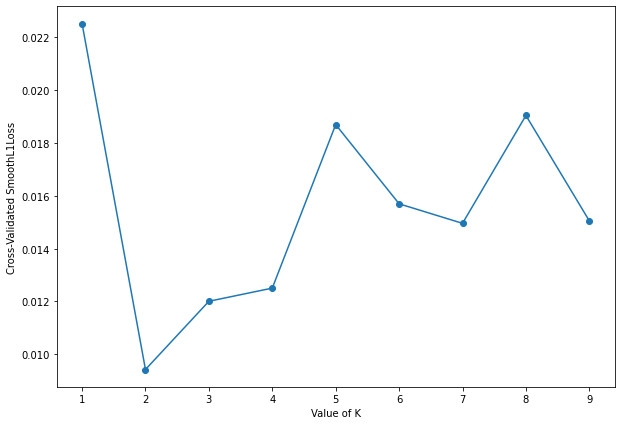

In [6]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [17]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [18]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.03946136683225632
Epoch 10 train loss: 0.02337457239627838
Epoch 20 train loss: 0.0226453747600317
Epoch 30 train loss: 0.021759498864412308


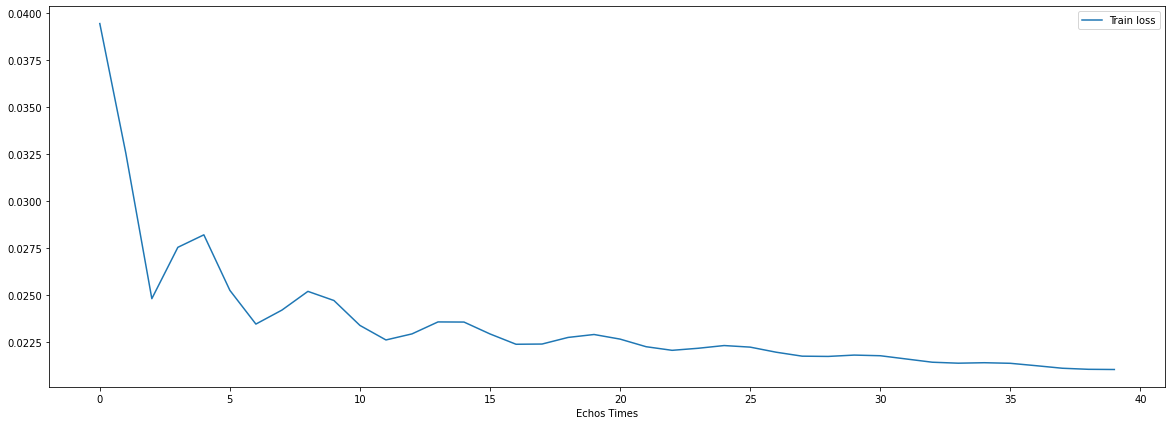

In [19]:
myplot.model_loss({"Train loss":train_hist_original}, path=plot_path+"original_loss.png")

## Windshear Features

In [7]:
model_wsr = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [8]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03905431926250458 test loss: 0.03207283094525337
Epoch 10 train loss: 0.013006679713726044 test loss: 0.012379787862300873
Epoch 20 train loss: 0.009478289633989334 test loss: 0.010346315801143646
Epoch 30 train loss: 0.008475452661514282 test loss: 0.008864769712090492
Epoch 39 train loss: 0.008332056924700737 test loss: 0.008242866024374962
Epoch 0 train loss: 0.008746362291276455 test loss: 0.004731874447315931
Epoch 10 train loss: 0.01026215311139822 test loss: 0.0059027038514614105
Epoch 20 train loss: 0.008593328297138214 test loss: 0.004659378435462713
Epoch 30 train loss: 0.008554799482226372 test loss: 0.0045894901268184185
Epoch 39 train loss: 0.008537993766367435 test loss: 0.004569239914417267
Epoch 0 train loss: 0.00835548434406519 test loss: 0.005974173080176115
Epoch 10 train loss: 0.009725015610456467 test loss: 0.006688537076115608
Epoch 20 train loss: 0.008348964154720306 test loss: 0.005940721835941076
Epoch 30 train loss: 0.008275141008198261 t

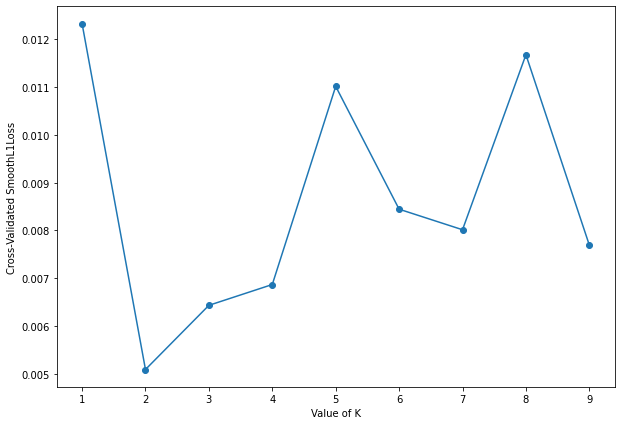

In [9]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [21]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [22]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.027466963976621628
Epoch 10 train loss: 0.013898390345275402
Epoch 20 train loss: 0.01261724904179573
Epoch 30 train loss: 0.012045715935528278


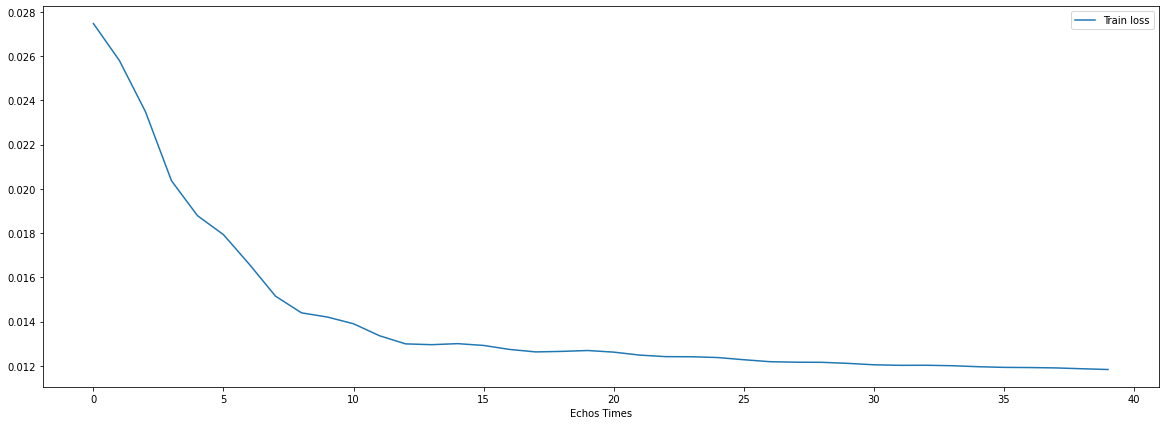

In [23]:
myplot.model_loss({"Train loss":train_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [10]:
model_geo = MLP_Regression(
  input_size=49,
  hidden_size=hidden_size
)

In [11]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03801463544368744 test loss: 0.03097093105316162
Epoch 10 train loss: 0.012450856156647205 test loss: 0.011957917362451553
Epoch 20 train loss: 0.00974814873188734 test loss: 0.010669226758182049
Epoch 30 train loss: 0.008796482346951962 test loss: 0.009007986634969711
Epoch 39 train loss: 0.0086372597143054 test loss: 0.0084533067420125
Epoch 0 train loss: 0.009023950435221195 test loss: 0.004771675448864698
Epoch 10 train loss: 0.009043184109032154 test loss: 0.004804287571460009
Epoch 20 train loss: 0.008898357860744 test loss: 0.004749180283397436
Epoch 30 train loss: 0.008785462938249111 test loss: 0.004663414787501097
Epoch 39 train loss: 0.008739867247641087 test loss: 0.004635483026504517
Epoch 0 train loss: 0.008541841991245747 test loss: 0.006105693988502026
Epoch 10 train loss: 0.008543248288333416 test loss: 0.006213846616446972
Epoch 20 train loss: 0.008497613482177258 test loss: 0.006133600603789091
Epoch 30 train loss: 0.00845397263765335 test loss:

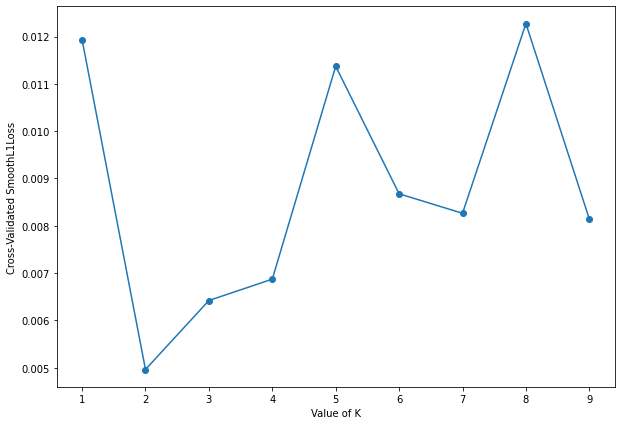

In [12]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [25]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [26]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.03554092347621918
Epoch 10 train loss: 0.012255990877747536
Epoch 20 train loss: 0.00973622128367424
Epoch 30 train loss: 0.00888020545244217


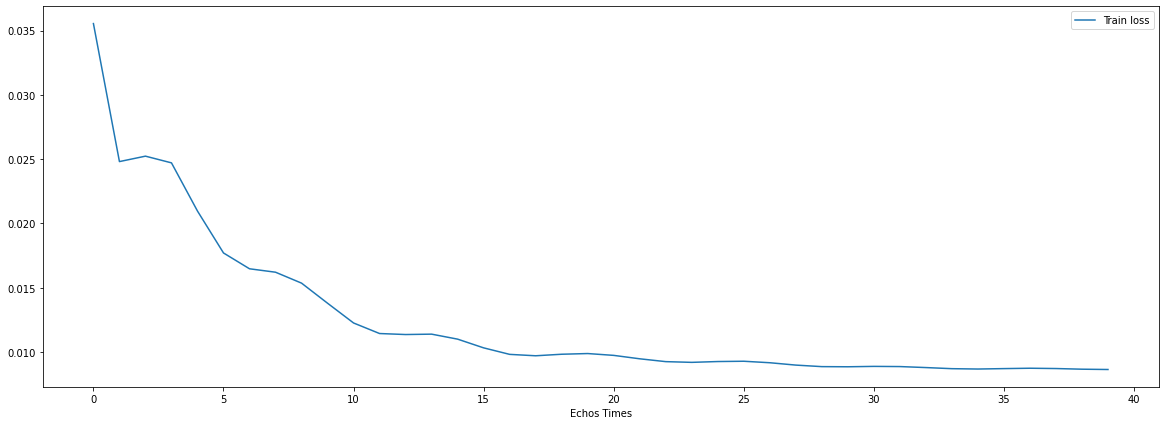

In [27]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [13]:
model_semigeo = MLP_Regression(
  input_size=50,
  hidden_size=hidden_size
)

In [14]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.040063466876745224 test loss: 0.03413374722003937
Epoch 10 train loss: 0.01514921709895134 test loss: 0.013656110502779484
Epoch 20 train loss: 0.009611550718545914 test loss: 0.010285893455147743
Epoch 30 train loss: 0.008603624999523163 test loss: 0.008707272820174694
Epoch 39 train loss: 0.008366607129573822 test loss: 0.008202736265957355
Epoch 0 train loss: 0.008703570812940598 test loss: 0.0047176191583275795
Epoch 10 train loss: 0.008814512751996517 test loss: 0.004780609160661697
Epoch 20 train loss: 0.008578287437558174 test loss: 0.004632425028830767
Epoch 30 train loss: 0.008432839065790176 test loss: 0.004527076613157988
Epoch 39 train loss: 0.008366989903151989 test loss: 0.00448424369096756
Epoch 0 train loss: 0.008186491206288338 test loss: 0.005794280208647251
Epoch 10 train loss: 0.00876291561871767 test loss: 0.006147533655166626
Epoch 20 train loss: 0.008522538468241692 test loss: 0.0060079339891672134
Epoch 30 train loss: 0.008246426470577717 t

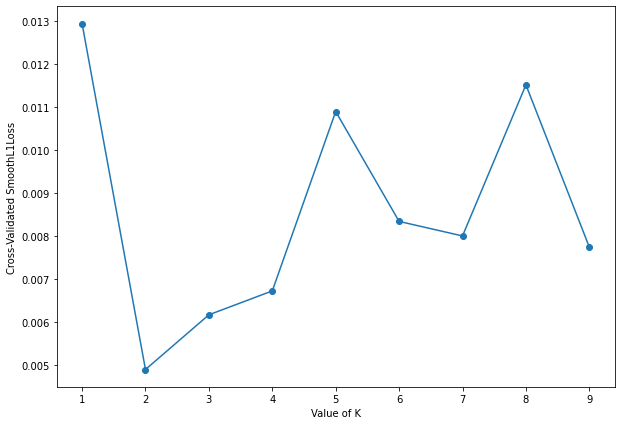

In [15]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [29]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [30]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.03598012402653694
Epoch 10 train loss: 0.01507418230175972
Epoch 20 train loss: 0.012989629060029984
Epoch 30 train loss: 0.012374399229884148


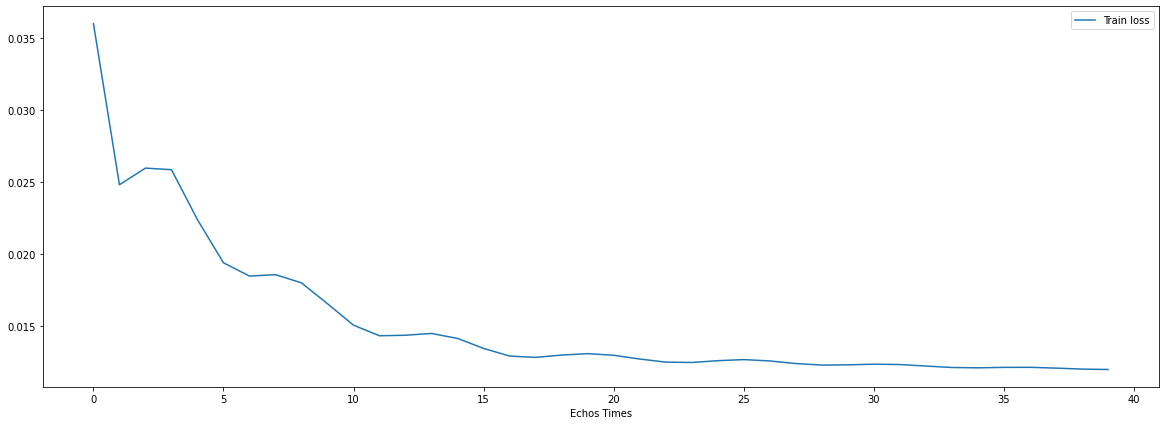

In [31]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")